In [238]:
# 그래프 스타일 ggplot설정
plt.style.use("ggplot")

### 1. 데이터 불러오기

In [137]:
# 날짜별 제품별 데이터를 불러오기위한 쿼리 작성
query = '''
select date, prod.v2ProductCategory as category,prod.v2ProductName as name, 
    sum(prod.productQuantity) as qty , sum(prod.productPrice*prod.productQuantity) as sales
from `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    left join unnest(hits) as hits
    left join unnest(hits.product) as prod
where _table_suffix between '20170701' and '20170801'
    and hits.eCommerceAction.action_type = '6'
    and prod.productQuantity is not null
group by date, prod.v2ProductCategory, prod.v2ProductName

'''

In [138]:
# 빅쿼리에서 데이터를 불러옵니다.
df = pd.read_gbq(query = query, dialect = 'standard', project_id = 'public-data-projects')

In [139]:
# 데이터 미리보기
print(df.shape)
df.head()

(2265, 5)


,date,category,name,qty,sales
0,20170716,Drinkware,Foam Can and Bottle Cooler,21,28910000
1,20170716,Notebooks & Journals,YouTube RFID Journal,1,6000000
2,20170716,Apparel,Google Men's Short Sleeve Performance Badge Te...,1,12310000
3,20170716,Apparel,Google Women's Short Sleeve Hero Tee Sky Blue,1,15190000
4,20170716,Drinkware,Red Shine 15 oz Mug,4,41560000


### 2. 전처리

In [140]:
# 데이터 info를 봅니다.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2265 entries, 0 to 2264
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      2265 non-null   object
 1   category  2265 non-null   object
 2   name      2265 non-null   object
 3   qty       2265 non-null   int64 
 4   sales     2265 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 88.6+ KB


In [141]:
# date의 데이터타입을 datetime으로 바꿔줍니다.
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2265 entries, 0 to 2264
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2265 non-null   datetime64[ns]
 1   category  2265 non-null   object        
 2   name      2265 non-null   object        
 3   qty       2265 non-null   int64         
 4   sales     2265 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 88.6+ KB


In [142]:
# 결측치는 없습니다.
df.isna().sum()

date        0
category    0
name        0
qty         0
sales       0
dtype: int64

In [143]:
# ga에서 불러온 sales값은 10의6승이 곱해져있으므로 나눠줍니다.
df['sales'] = df['sales']/np.power(10,6)
df.head()

,date,category,name,qty,sales
0,2017-07-16,Drinkware,Foam Can and Bottle Cooler,21,28.91
1,2017-07-16,Notebooks & Journals,YouTube RFID Journal,1,6.00
2,2017-07-16,Apparel,Google Men's Short Sleeve Performance Badge Te...,1,12.31
3,2017-07-16,Apparel,Google Women's Short Sleeve Hero Tee Sky Blue,1,15.19
4,2017-07-16,Drinkware,Red Shine 15 oz Mug,4,41.56


In [144]:
# ${productitem.product.origCatName}라는 이상한 카테고리가 섞여 있습니다.
df['category'].value_counts()

Apparel                               1097
Office                                 319
Drinkware                              144
Lifestyle                              139
Bags                                   134
Electronics                            100
Notebooks & Journals                    97
Headgear                                73
${productitem.product.origCatName}      59
Bottles                                 25
Fun                                     19
Waze                                    19
Housewares                              10
Android                                  6
Accessories                              6
Backpacks                                6
Google                                   6
Gift Cards                               6
Name: category, dtype: int64

In [145]:
# 해당 카테고리의 제품들이 여러 카테고리가 섞여있는 듯 합니다.
# 수가 많지 않아 'unclassified'로 정리해 줍니다.
df['category'][df['category'] == '${productitem.product.origCatName}'] = 'unclassified'
df['category'].value_counts()


<ipython-input-145-9e2e7ab8fdca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'][df['category'] == '${productitem.product.origCatName}'] = 'unclassified'


Apparel                 1097
Office                   319
Drinkware                144
Lifestyle                139
Bags                     134
Electronics              100
Notebooks & Journals      97
Headgear                  73
unclassified              59
Bottles                   25
Fun                       19
Waze                      19
Housewares                10
Android                    6
Accessories                6
Backpacks                  6
Google                     6
Gift Cards                 6
Name: category, dtype: int64

### 3. 카테고리 별 제품 별 분석

In [187]:
# 데이터를 카테고리별로 집계합니다.
df_cate = df.pivot_table(values = ['qty','sales'], index = 'category', aggfunc = 'sum' )

In [188]:
# 미리보기 합니다.
print(df_prod.shape)
df_cate.head(10)

(18, 2)


,qty,sales
category,,
Accessories,44,1862.36
Android,7,93.53
Apparel,4073,61879.14
Backpacks,10,859.90
Bags,1169,12351.39
Bottles,238,886.22
Drinkware,2765,13487.84
Electronics,811,10145.49
Fun,146,652.42


In [189]:
# 매출순으로 상위 10개만 조회합니다. 상위 카테고리에 매출이 몰린 걸 볼 수 있습니다.
df_cate.sort_values('sales', ascending = False).head(10)

,qty,sales
category,,
Apparel,4073,61879.14
Notebooks & Journals,2395,24116.40
Office,5114,21170.63
Drinkware,2765,13487.84
Bags,1169,12351.39
Electronics,811,10145.49
Lifestyle,2863,8608.98
Headgear,213,2528.80
unclassified,280,2292.39


In [190]:
# 더 직관적으로 보기 위해 퍼센티지 칼럼을 추가해줍니다.
df_cate['percentage'] = df_cate['sales']/df_cate['sales'].sum()*100
df_cate.head()

,qty,sales,percentage
category,,,
Accessories,44,1862.36,1.134238
Android,7,93.53,0.056963
Apparel,4073,61879.14,37.686405
Backpacks,10,859.90,0.523707
Bags,1169,12351.39,7.522397


In [191]:
# 시각화를 위해 reset_index 해줍니다.
df_cate = df_cate.reset_index()
# 상위 10개 카테고리 데이터를 df_cate_10에 할당합니다.
df_cate_10 = df_cate.sort_values('percentage', ascending = False).head(10)

<AxesSubplot:xlabel='category', ylabel='percentage'>

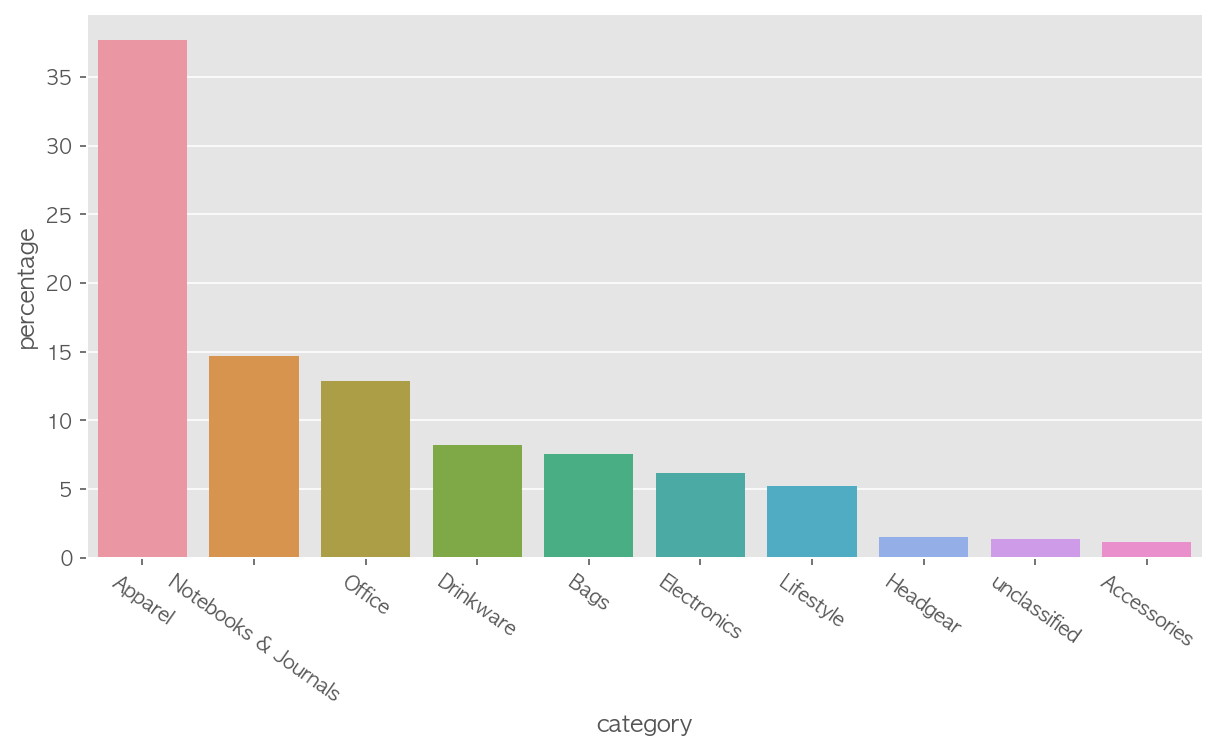

In [239]:
# 카테고리별 퍼센티지를 시각화합니다. 
# 어페럴 카테고리의 매출 비중이 35%나 됩니다.
# 상위 7개 카테고리 이후로는 퍼센티지가 미미합니다.
plt.figure(figsize = (10,5))
plt.xticks(rotation = -35)
sns.barplot(data = df_cate_10, x = 'category', y = 'percentage')

In [250]:
# 상위 7개의 인덱스를 top7에 할당합니다.
top7 = df_cate.sort_values('percentage', ascending = False).head(7)['category']
# 상위 7개 카테고리에 해당하는지 여부를 'is_top7'칼럼에 추가합니다.
df_cate['is_top7'] = df_cate['category'].isin(top7)
df_cate.head()

,category,qty,sales,percentage,is_top7
0,Accessories,44,1862.36,1.134238,False
1,Android,7,93.53,0.056963,False
2,Apparel,4073,61879.14,37.686405,True
3,Backpacks,10,859.90,0.523707,False
4,Bags,1169,12351.39,7.522397,True


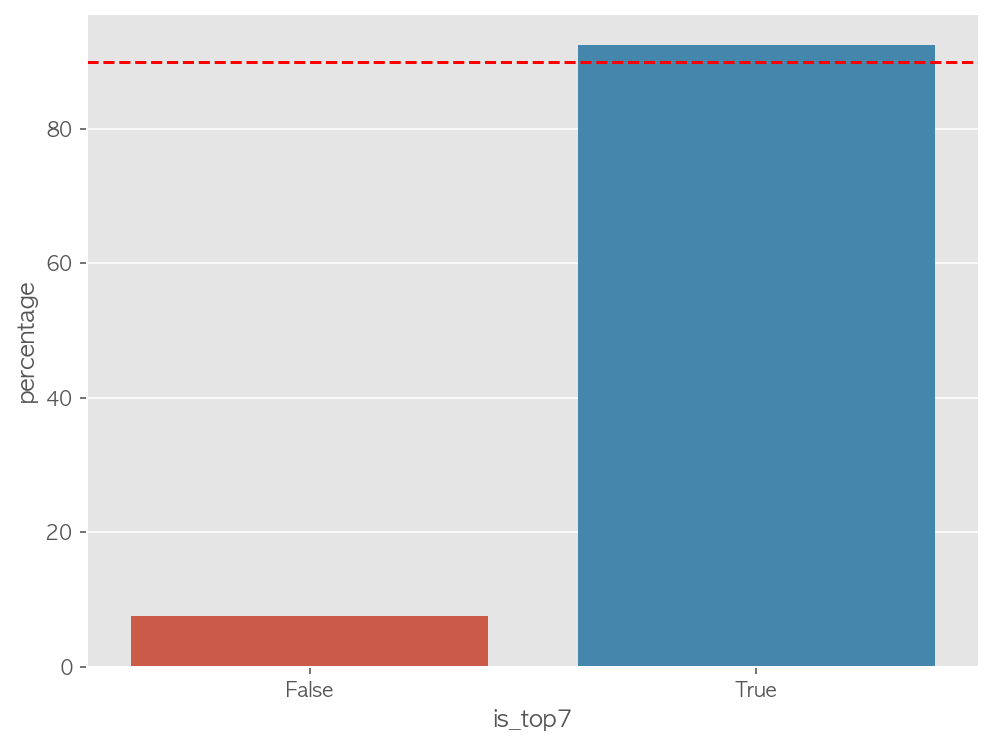

In [258]:
# 상위 7개 카테고리가 매출의 90%를 넘게 이끌고 있습니다.
# 이 분류를 기준으로 제품 매출 개선 전략을 만들 수 있을 것입니다.
plt.figure(figsize = (8,6))

plt.axhline(y = 90, color = 'r', ls = '--')
g = sns.barplot(data = df_cate, x = 'is_top7', y = 'percentage', ci = False, estimator = sum)

In [269]:
# top7 카테고리에 해당하는 데이터를 조회합니다.
df[df['category'].isin(top7)].head()

,date,category,name,qty,sales
0,2017-07-16,Drinkware,Foam Can and Bottle Cooler,21,28.91
1,2017-07-16,Notebooks & Journals,YouTube RFID Journal,1,6.00
2,2017-07-16,Apparel,Google Men's Short Sleeve Performance Badge Te...,1,12.31
3,2017-07-16,Apparel,Google Women's Short Sleeve Hero Tee Sky Blue,1,15.19
4,2017-07-16,Drinkware,Red Shine 15 oz Mug,4,41.56


In [265]:
# top7에 해당하는 제품들만 집계합니다.
df_best_prod = df[df['category'].isin(top7)].groupby(['name'])[['qty','sales']].sum().reset_index()
df_best_prod.head()

,name,qty,sales
0,1 oz Hand Sanitizer,43,73.97
1,20 oz Stainless Steel Insulated Tumbler,13,299.87
2,23 oz Wide Mouth Sport Bottle,68,599.92
3,26 oz Double Wall Insulated Bottle,106,2333.94
4,7&quot; Dog Frisbee,90,119.40


In [266]:
# top7카테고리에 해당하는 제품 중 매출 상위 40개만 분류합니다.
df_best_40 = df_best_prod.sort_values('sales', ascending = False).head(40)
df_best_40.head(10)

,name,qty,sales
222,YouTube Hard Cover Journal,389,5597.11
61,Google Baby Essentials Set,231,5520.65
132,Google Spiral Journal with Pen,797,5359.03
71,Google Hard Cover Journal,346,5114.54
135,Google Sunglasses,1626,4639.60
193,Leatherette Journal,619,4596.87
57,Google 22 oz Water Bottle,1517,4340.83
86,Google Men's 100% Cotton Short Sleeve Hero Tee...,247,3989.13
209,Sport Bag,668,3225.32
201,Recycled Paper Journal Set,830,2912.50


<AxesSubplot:ylabel='name'>

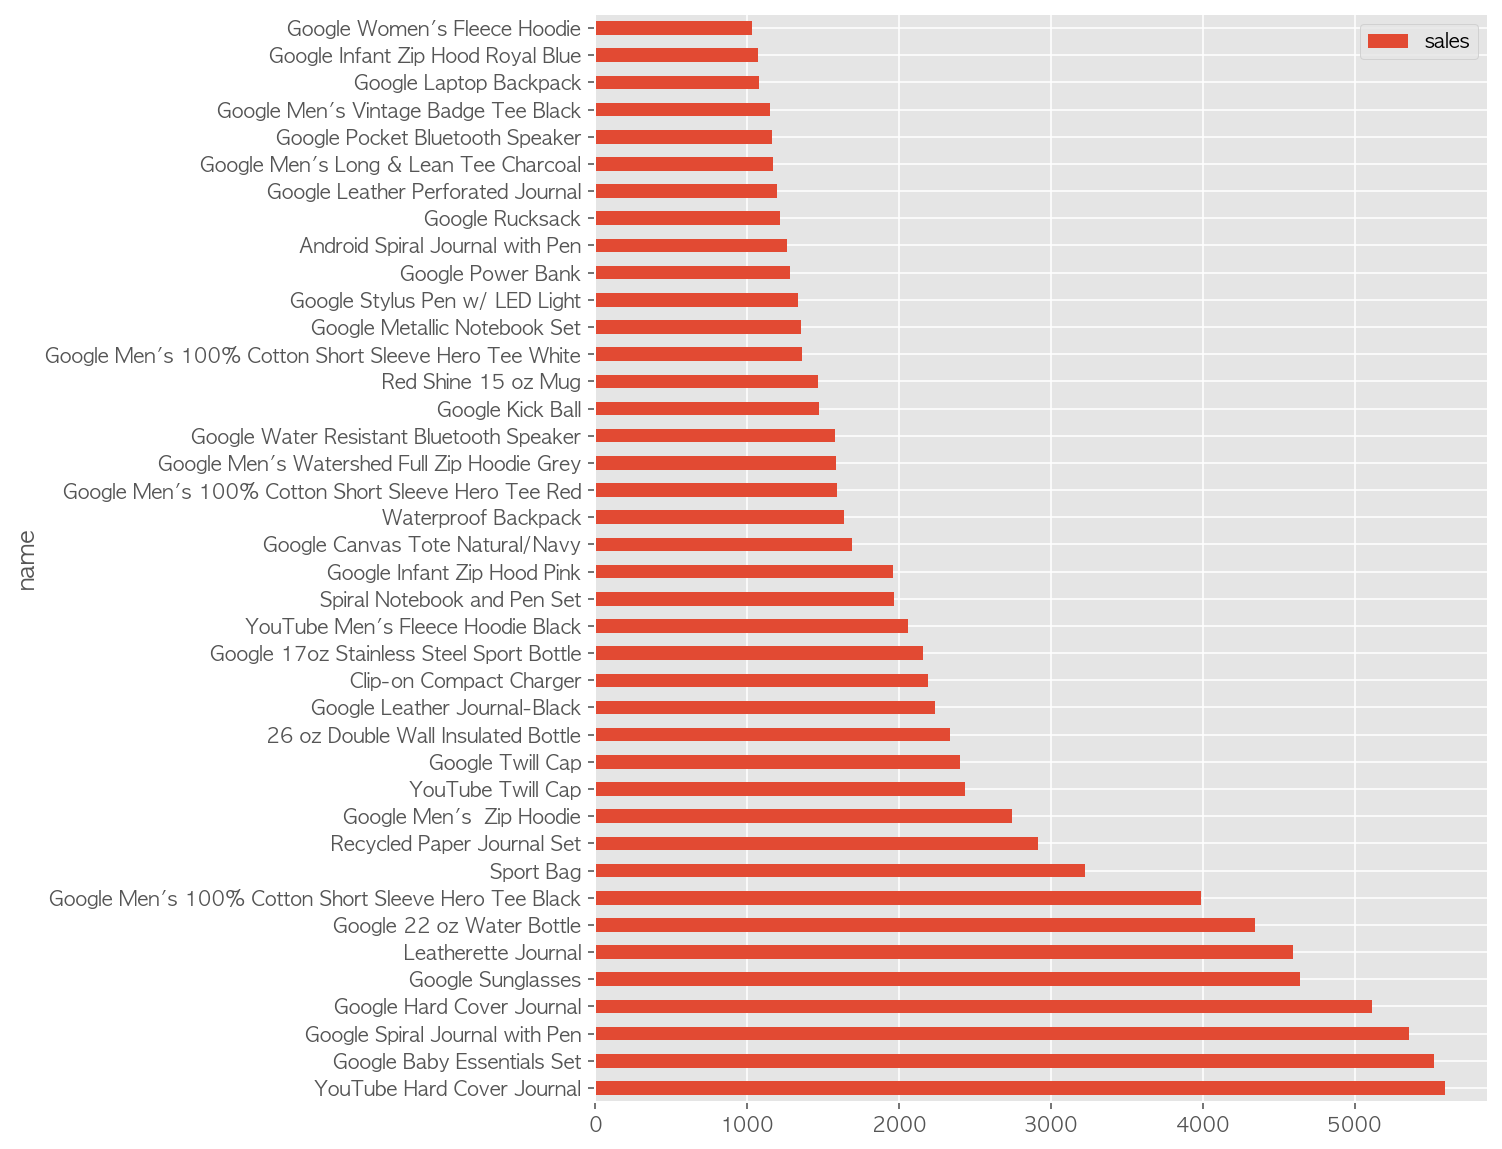

In [267]:
# 시각화하여 매출분포를 살펴봅니다.
# 이 그룹내에서도 상위 제품들에 매출이 몰려있는걸 볼 수 있습니다.
df_best_40.plot(kind = 'barh', x = 'name', y = 'sales', figsize = (8,10))

In [270]:
# (매출의 90%를 차지하는)top7카테고리의 top10매출 아이템은 다음과 같습니다.
# 해당 아이템들의 제품특성이나 주 구매자 특성을 추가 분석하면 인사이트를 더 얻을 수 있습니다.
best_items = df_best_40.head(10)['name'].values
best_items

array(['YouTube Hard Cover Journal', 'Google Baby Essentials Set',
       'Google Spiral Journal with Pen', 'Google Hard Cover Journal',
       'Google Sunglasses', 'Leatherette Journal',
       'Google 22 oz Water Bottle',
       "Google Men's 100% Cotton Short Sleeve Hero Tee Black",
       'Sport Bag', 'Recycled Paper Journal Set'], dtype=object)

#### 인사이트
- 7월 매출은 상위 카테고리 7개에 90%가 몰려있다.
    - 그중에서도 매출을 이끌고 있는 top10 아이템들이 있고, 추가 분석을 진행하면 인사이트가 더 나올 것이다.


### 4. 일자 별 분석

In [294]:
df_date = df.groupby(['date'])[['qty','sales']].sum()
df_date.reset_index(inplace = True)
df_date.head()

,date,qty,sales
0,2017-07-01,6,84.54
1,2017-07-02,22,634.99
2,2017-07-03,102,1264.42
3,2017-07-04,42,379.98
4,2017-07-05,1161,8061.53


<AxesSubplot:xlabel='date', ylabel='sales'>

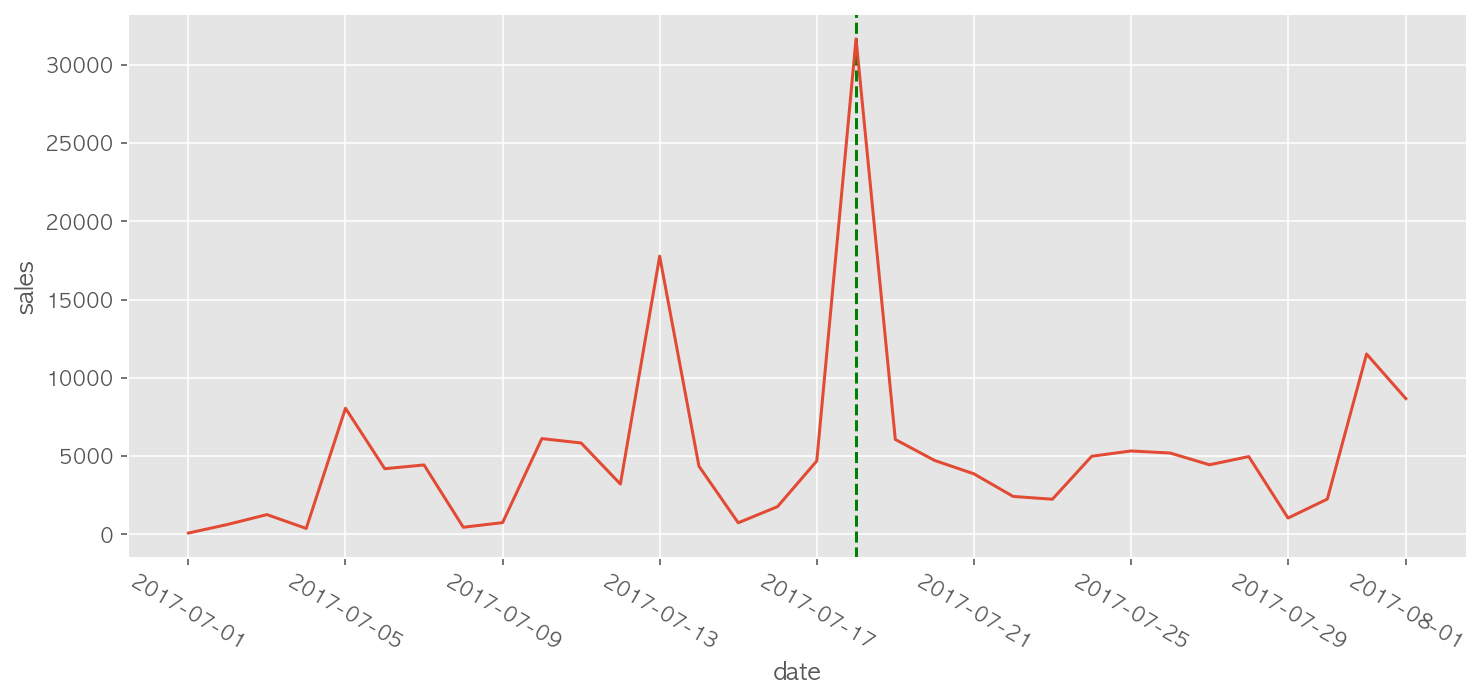

In [302]:
from datetime import datetime

plt.figure(figsize = (12,5))
plt.xticks(rotation = -30)
plt.axvline(x = datetime(2017,7,18), color = 'g', ls = '--')

sns.lineplot(data = df_date, x = 'date',y = 'sales')

In [319]:
df_1719 = df[(df['date'] >= '2017-07-17')&(df['date'] <= '2017-07-19')&(df['category'].isin(top7))]
df_1719.head()

,date,category,name,qty,sales
23,2017-07-19,Apparel,Google Men's 100% Cotton Short Sleeve Hero Tee...,1,16.99
24,2017-07-19,Office,YouTube Leatherette Notebook Combo,30,167.70
25,2017-07-19,Apparel,Google Men's Vintage Badge Tee Sage,5,23.94
26,2017-07-19,Apparel,Google Men's Short Sleeve Badge Tee Charcoal,1,10.63
27,2017-07-19,Lifestyle,Windup Android,3,9.57


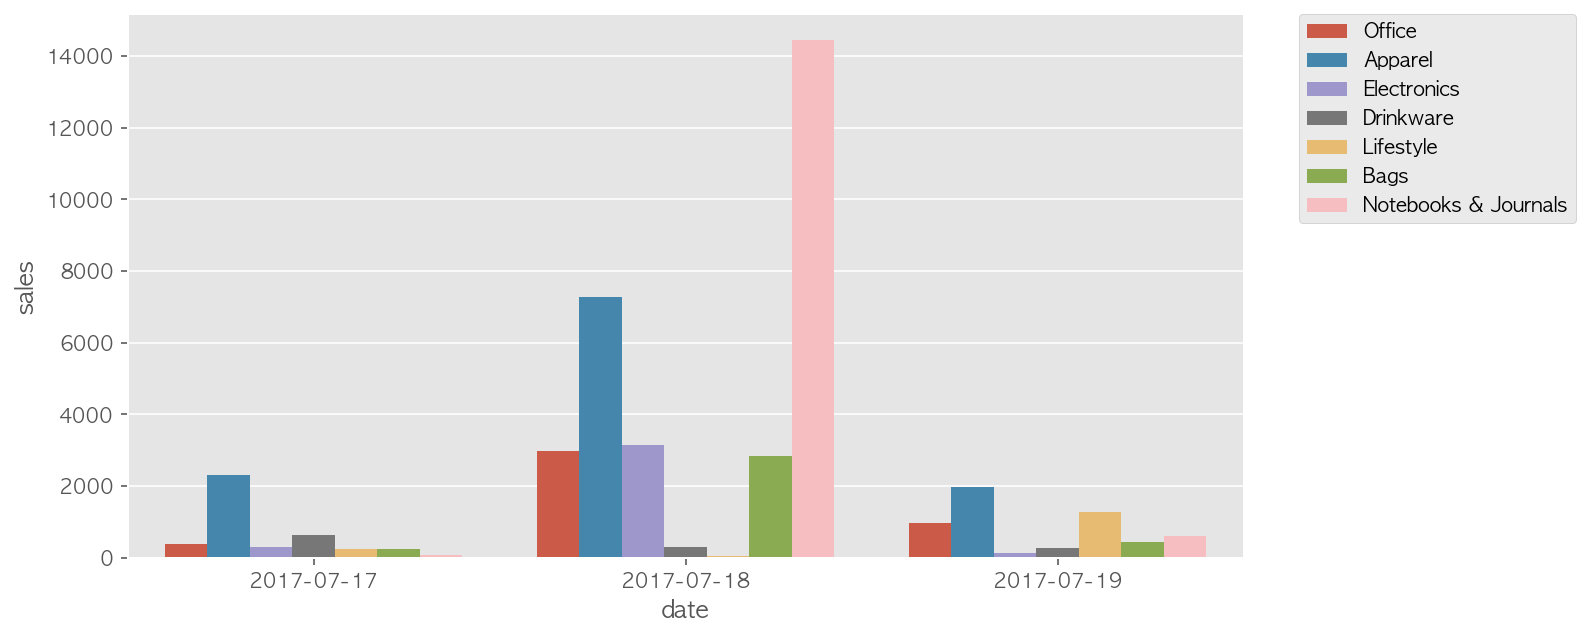

In [349]:
# 사이즈 수정
plt.figure(figsize = (10,5))
# 날짜별 매출, 색상으로 카테고리 구분
g = sns.barplot(data = df_1719.sort_values('date'),
                x = 'date', y = 'sales', hue = 'category', 
                estimator = sum,ci = False)

# 날짜 포멧 수정
g.set_xticklabels([date_text.get_text().split("T")[0] for date_text in g.get_xticklabels()])
# legend 밖으로
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# 전후일과 비교했을 때 Office, Apparel, Electronics, Bags, Notebooks 카테고리 매출이 증가한걸 볼 수 있습니다.
# 특히 Notebooks카테고리가 눈에띄게 매출이 증가했습니다.
# 해당 카테고리 매출이 증가한 마케팅적, 상황적 요인을 분석하면, 매출 증가 인사이트를 더 자세히 알 수 있을 것입니다.

#### 인사이트
- 7월 18일 매출이 급증하였다.
- 해당 날짜에 급증한 이유는 다음 5개의 카테고리에서 매출이 증가했기 때문이다.
    - Office, Apparel, Electronics, Bags, Notebooks
- 그중에서도 Notebooks & Journals 카테고리가 가장 눈에 띄게 증가했다.
- 해당 카테고리 매출이 증가한 마케팅적, 상황적 요인을 분석하면, 매출 증가 인사이트를 더 자세히 알 수 있을 것이다.